In [ ]:
!pip install tensorflow==2.15

In [ ]:
# Установка autokeras
!pip install autokeras

# Классификация изображений

In [ ]:
# Подключение библиотек
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [ ]:
#@title дополнительные функции
def samples(directory_path, grid_size):
    """
    Функция, которая выводит на экран случайные изображения из указанной директории.

    Параметры:
        directory_path (str): Путь к директории с изображениями.
        grid_size (tuple): Кортеж из двух чисел (rows, cols), задающий размер сетки вывода изображений.

    """
    # Проверяем существование директории
    if not os.path.exists(directory_path) or not os.path.isdir(directory_path):
        print(f"Директория '{directory_path}' не существует или не является директорией.")
        return

    # Извлекаем количество строк и столбцов из grid_size
    rows, cols = grid_size

    # Получаем список всех файлов в директории
    file_list = os.listdir(directory_path)

    # Перемешиваем файлы в случайном порядке
    random.shuffle(file_list)

    # Выбираем только указанное количество файлов
    num_images = rows * cols
    random_images = file_list[:num_images]

    # Создаем сетку для вывода изображений
    fig, axs = plt.subplots(rows, cols, figsize=(10, 8))

    # Выводим изображения на экран
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(directory_path, random_images[i * cols + j])
            img = mpimg.imread(image_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')  # Отключаем оси координат для чистоты вывода

    # Показываем сетку с изображениями
    plt.tight_layout()
    plt.show()

## Ручная подготовка данных

In [ ]:
import gdown

# Загрузка обучающих изображений
URL = 'https://storage.yandexcloud.net/terraai/sources/bus.zip'
gdown.download(URL, None, quiet = True)

'bus.zip'

In [ ]:
# Распаковка архива
!unzip -q bus.zip -d '/content/data'

# Удаление архива
!rm -rf bus.zip

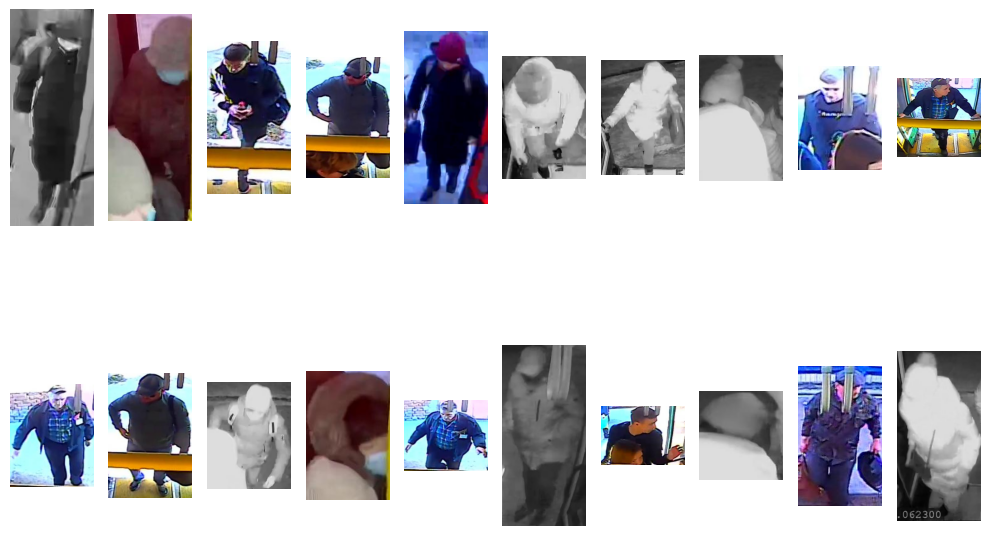

In [ ]:
# Демонстрация примеров с помощью ранее созданной функции samples для входящих
samples(
    directory_path='data/Входящий',
    grid_size=(2, 10)
)

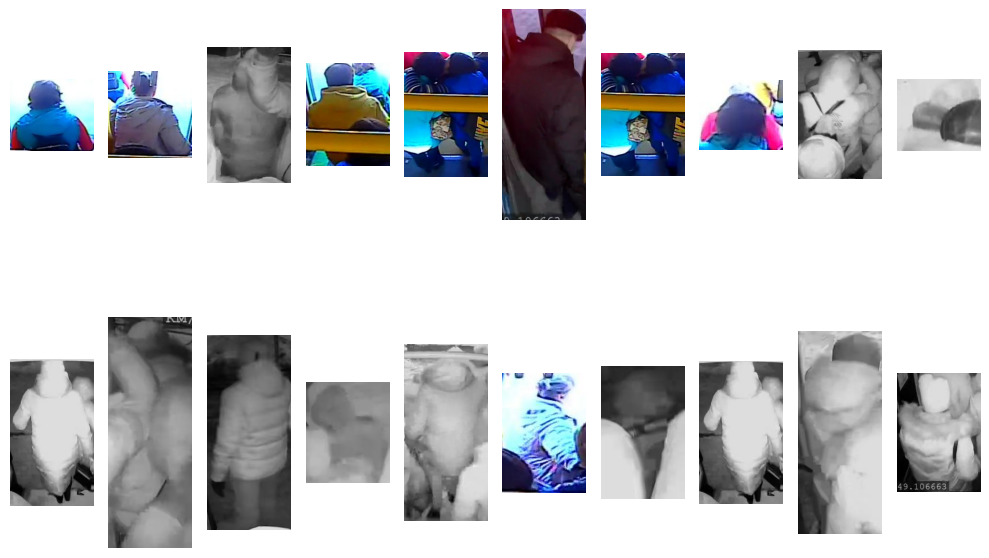

In [ ]:
# Демонстрация примеров с помощью ранее созданной функции samples для выходящих
samples(
    directory_path='data/Выходящий',
    grid_size=(2, 10)
)

In [ ]:
# Импортируем функции загрузки изображений, перевода изображения в формат array,
# разбиения на тренировочную и проверочную выборки
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

def prepare_data(directory_path, target_size=(64, 64)):
    """
    Подготавливает данные для обучения модели.

    Параметры:
        directory_path (str): Путь к директории с изображениями.
        target_size (tuple): Размер изображений, на которые они будут приведены перед обучением.

    Возвращает:
        Массивы numpy для обучающих и валидационных данных и меток классов.
    """
    # Создаем списки для данных и меток
    x_data, y_data = [], []
    x_train, y_train, x_val, y_val = [], [], [], []

    # Проходимся по всем поддиректориям и файлам в директории
    for root, _, files in os.walk(directory_path):
        for file_ in files:
            file_path = os.path.join(root, file_)
            # Загружаем изображение и преобразуем его в массив numpy
            img = load_img(file_path, target_size=target_size)
            x_data.append(img_to_array(img))
            y_data.append(1 if "Выходящий" in root else 0)

    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data, shuffle=True)

    # Преобразуем списки в массивы numpy
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_val = np.array(x_val)
    y_val = np.array(y_val)

    return x_train, y_train, x_val, y_val

In [ ]:
# Подготавливаем данные с помощью ранее созданной функции prepare_data
x_train, y_train, x_val, y_val = prepare_data('data')
# Выводим размеры массивов
print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')

x_train shape: (7264, 64, 64, 3), y_train shape: (7264,)
x_val shape: (1817, 64, 64, 3), y_val shape: (1817,)


In [ ]:
# Импортируем ранее установленный Autokeras
import autokeras as ak

# Инициализируем классификатор AutoKeras
clf = ak.ImageClassifier(overwrite=False,  # перезаписываем проект
                         max_trials=2)    # количество разных моделей Keras


In [ ]:
# Обучаем модель
clf.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64)

Trial 1 Complete [00h 00m 15s]
val_loss: 0.3385085463523865

Best val_loss So Far: 0.3385085463523865
Total elapsed time: 00h 00m 15s
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7162 - loss: 0.6236 - val_accuracy: 0.8222 - val_loss: 0.3591


In [ ]:
# Создание объекта классификатора
clf = ak.ImageClassifier(
      overwrite=True,                  # перезаписываем проект
      max_trials=2,                    # количество разных моделей Keras
      num_classes=None,                # если None, то оно будет получено из данных.
      multi_label=False,               # мультиклассовая классификация
      loss='binary_crossentropy',      # по умолчанию подбирается в зависимости от количества классов
      metrics=['accuracy'],            # используется по умолчанию
      project_name='drive/MyDrive/bus_project',      # имя по умолчанию 'image_classifier'
      directory='result',              # путь для сохранения результатов
      seed=42,                         # позволяет воспроизводить результаты обучения на разных машинах
      max_model_size=None,             # mаксимальное количество скалярных параметров в модели
      tuner=None,                      # устанавливает алгоритм поиска архитектуры и гиперпараметров модели под задачу
      objective='val_accuracy')        # метрика модели для минимизации или максимизации

In [ ]:
# Обучаем модель
clf.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=64)

Trial 1 Complete [00h 00m 14s]
val_accuracy: 0.8365437388420105

Best val_accuracy So Far: 0.8365437388420105
Total elapsed time: 00h 00m 14s
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.7132 - loss: 0.6008 - val_accuracy: 0.8442 - val_loss: 0.3375


In [ ]:
model = clf.export_model() # Экспорт модели
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          57,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Activation)   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,000 (300.79 KB)

 Trainable params: 76,993 (300.75 KB)

 Non-trainable params: 7 (32.00 B)

In [ ]:
# Более гибкий подход к построению модели с использованием функционального
# программирования (AutoModel) с помощью блоков Autokeras

input_node = ak.ImageInput()    # входной слой
output_node = ak.ImageBlock(    # основной слой
    block_type="vanilla",       # используемая архитектура
    normalize=True,             # слои локанальной нормализации
    augment=True,               # слои аугментации
)(input_node)

output_node = ak.ClassificationHead()(output_node)  # выходной слой (классификатор)

# Инициализируем классификатор AutoModel с 10 вариантами моделей
clf = ak.AutoModel(inputs=input_node,
                   outputs=output_node,
                   overwrite=True,
                   max_trials=10)

In [ ]:
# Обучаем модель
clf.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)

Trial 1 Complete [00h 00m 14s]
val_loss: 0.45952507853507996

Best val_loss So Far: 0.45952507853507996
Total elapsed time: 00h 00m 14s
114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7057 - loss: 0.5599 - val_accuracy: 0.7755 - val_loss: 0.4546


In [ ]:
# Сохраняем модель
model = clf.export_model()
model.save('model.keras')
#  Вывод структуры нейронной сети
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_to_float32 (CastToFloat32)      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 3)           │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           5,409 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification_head_1 (Activation)   │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,056 (133.04 KB)

 Trainable params: 34,049 (133.00 KB)

 Non-trainable params: 7 (32.00 B)

# Классификация текстов

In [ ]:
# Устанановка необходимых библиотек нужной версии
# !Требуется перезапуск среды!
!pip -q install --upgrade gdown
!pip -q uninstall -y pyarrow
!pip -q install pyarrow==16.1.0
!pip -q uninstall -y pydantic
!pip -q install pydantic==1.10.13
!pip -q install autokeras==1.0.20
!pip -q install tensorflow==2.13.1

!pip -q install gensim scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.3 requires pydantic>=2.9.2, but you have pydantic 1.10.13 which is incompatible.
langchain 0.3.17 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 1.10.13 which is incompatible.
google-genai 0.8.0 requires pydantic<3.0.0dev,>=2.0.0, but you have pydantic 1.10.13 which is incompatible.
wandb 0.19.6 requires pydantic<3,>=2.6, but you have pydantic 1.10.13 which is incompatible.
langchain-core 0.3.33 requires pydantic<3.0.0,>=2.5.2; python_full_version < "3.12.4", but you have pydantic 1.10.13 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import gdown
import re
import autokeras as ak
from tensorflow.keras.models import load_model

In [ ]:
# Загрузка данных датасета

import gdown
gdown.download('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/mZLVO_4wADglFw', 'texts_full.zip', quiet=False)

Downloading...
From: https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/mZLVO_4wADglFw
To: /content/texts_full.zip
100%|██████████| 24.6M/24.6M [00:02<00:00, 10.2MB/s]


'texts_full.zip'

In [ ]:
!unzip /content/texts_full.zip # Распаковка архива

Archive:  /content/texts_full.zip
  inflating: topic_culture.txt       
  inflating: topic_economics.txt     
  inflating: topic_incident.txt      
  inflating: topic_politics.txt      
  inflating: topic_sport.txt         


In [ ]:
def transform_to_seq(path, num_category):
    # Открываем файл с текстом
    with open(path, 'r', encoding='utf-8') as file:
        text = file.read()

    # Находим все фрагменты текста в кавычках
    fragments = re.findall(r'"(.*?)"', text)

    # Разбиваем фрагменты на части, не превышающие 500 символов, и исключаем фрагменты меньше 500 символов
    x_data = []
    for fragment in fragments:
        while len(fragment) > 500:
            x_data.append(fragment[:500])
            fragment = fragment[500:]
        if len(fragment) == 500:
            x_data.append(fragment)

    # Создаем переменную y_train с категорией "0" для всех фрагментов
    y_data = [num_category] * len(x_data)

    return x_data, y_data

In [ ]:
# сохранение в переменные путей для файлов для последующих операций
path_0_culture = '/content/topic_culture.txt'
path_1_economics = '/content/topic_economics.txt'
path_2_incident = '/content/topic_incident.txt'
path_3_politics = '/content/topic_politics.txt'
path_4_sport = '/content/topic_sport.txt'

In [ ]:
# Ещё один шаг для формирования общей выборки: каждая новость для целевой train_x сопоставляется со своей категорией в целевую train_y
culture_x, culture_y = transform_to_seq(path_0_culture,0)
economics_x, economics_y = transform_to_seq(path_1_economics,1)
incident_x, incident_y = transform_to_seq(path_2_incident,2)
politics_x, politics_y = transform_to_seq(path_3_politics,3)
sport_x, sport_y = transform_to_seq(path_4_sport,4)

In [ ]:
# Определение длины каждой выборки по темам
len(culture_x), len(economics_x), len(incident_x), len(politics_x), len(sport_x)

(15970, 16333, 12313, 18797, 24125)

In [ ]:
# Определение длины каждой выборки по меткам соответствующих тем
len(culture_y), len(economics_y), len(incident_y), len(politics_y), len(sport_y)

(15970, 16333, 12313, 18797, 24125)

In [ ]:
# Находим минимальное количество элементов среди всех последовательностей
min_length = min(len(culture_x), len(economics_x), len(incident_x), len(politics_x), len(sport_x))

# Обрезаем все последовательности до минимальной длины
culture_x = culture_x[:min_length]
culture_y = culture_y[:min_length]

economics_x = economics_x[:min_length]
economics_y = economics_y[:min_length]

incident_x = incident_x[:min_length]
incident_y = incident_y[:min_length]

politics_x = politics_x[:min_length]
politics_y = politics_y[:min_length]

sport_x = sport_x[:min_length]
sport_y = sport_y[:min_length]


# Проверяем новые длины последовательностей
new_lengths_x = (len(culture_x), len(economics_x), len(incident_x), len(politics_x), len(sport_x))
new_lengths_y = (len(culture_y), len(economics_y), len(incident_y), len(politics_y), len(sport_y))
print(new_lengths_x, new_lengths_y)

(12313, 12313, 12313, 12313, 12313) (12313, 12313, 12313, 12313, 12313)


In [ ]:
# Создание генеральной выборки

data_x = culture_x + economics_x + incident_x + politics_x + sport_x
data_y = culture_y + economics_y + incident_y + politics_y + sport_y

In [ ]:
# Создаем список индексов
indices = list(range(len(data_x)))

# Перемешиваем индексы
random.shuffle(indices)

# Перемешиваем data_x и data_y по перемешанным индексам
shuffled_data_x = [data_x[i] for i in indices]
shuffled_data_y = [data_y[i] for i in indices]

# Проверяем длины перемешанных выборок
print("Длина shuffled_data_x:", len(shuffled_data_x))
print("Длина shuffled_data_y:", len(shuffled_data_y))

Длина shuffled_data_x: 61565
Длина shuffled_data_y: 61565


In [ ]:
# Определяем размер тренировочной выборки
train_size = int(0.8 * len(shuffled_data_x))

# Разделяем выборку на тренировочную и валидационную
train_x = shuffled_data_x[:train_size]
val_x = shuffled_data_x[train_size:]

train_y = shuffled_data_y[:train_size]
val_y = shuffled_data_y[train_size:]

# Проверяем размеры выборок
print("Размер тренировочной выборки (x):", len(train_x))
print("Размер валидационной выборки (x):", len(val_x))
print("Размер тренировочной выборки (y):", len(train_y))
print("Размер валидационной выборки (y):", len(val_y))

Размер тренировочной выборки (x): 49252
Размер валидационной выборки (x): 12313
Размер тренировочной выборки (y): 49252
Размер валидационной выборки (y): 12313


In [ ]:
# Преобразуем train_y и val_y в формат One-Hot Encoding
train_y_ohe = pd.get_dummies(train_y).values
val_y_ohe = pd.get_dummies(val_y).values

# Проверяем размеры преобразованных выборок
print("Размер тренировочной выборки (OHE):", train_y_ohe.shape)
print("Размер валидационной выборки (OHE):", val_y_ohe.shape)

Размер тренировочной выборки (OHE): (49252, 5)
Размер валидационной выборки (OHE): (12313, 5)


In [ ]:
# Инициируем объект TextClassifier
text_clf = ak.TextClassifier(
    max_trials=2,             # максимальное количество попыток для поиска лучшей модели
    overwrite=True,           # перезапись модели включена
    seed=42,                  # фиксируем случайную выборку
    num_classes=5,            # количество классов
    multi_label=False,        # мультиклассовая ли классификация
    metrics=["accuracy"],     # основная метрика
    objective="val_accuracy"  # целевая метрика, по ней будет совершенствоваться модель
)

In [ ]:
# Обучение модели

text_clf.fit(
    np.array(train_x).reshape(-1, 1),                 # x_train выборка, преобразованная в массив numpy в определенной размерности для подачи в модель
    train_y_ohe,                                      # y_train метки выборки: принадлежность фрагмента классу (вид One Hot Encoding)
    epochs=5,                                         # Количество эпох обучения
    batch_size=256,                                   # Размер батча
    validation_data=(np.array(val_x).reshape(-1, 1),  # Валидационная выборка
                     val_y_ohe))

Trial 1 Complete [00h 05m 26s]
val_accuracy: 0.7258182168006897

Best val_accuracy So Far: 0.7258182168006897
Total elapsed time: 00h 05m 26s
193/193 [==============================] - 282s 1s/step - loss: 1.2621 - accuracy: 0.4589 - val_loss: 0.7652 - val_accuracy: 0.7205


In [ ]:
# Экспорт модели
model = text_clf.export_model() # Экспорт модели из Autokeras в переменную для дальнейшей работы
model.save('model_text', save_format='tf')  # Указываем формат 'tf'
model.summary() # Вывод архитектуры модели

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 512)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 512, 64)           320064    
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 conv1d (Conv1D)             (None, 508, 256)          82176     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                             

In [ ]:
# загружаем ранее обученную модель
model = load_model('model_text')

In [ ]:
# Текст, который хотим классифицировать по одной из категорий

text =  '''Футбольный агент Сильвано Мартина, представляющий интересы бывшего голкипера туринского «Ювентуса» и сборной Италии Джанлуиджи Буффона, рассказал, что у голкипера никогда не было контактов с российскими клубами.

«Честно говоря, у него не было никаких контактов с российскими клубами. Возможно, они не думали об этом, поскольку он уже играл в топ-клубе», — приводит слова Мартины «РИА Новости Спорт».

45-летний Буффон объявил о завершении карьеры вчера, 2 августа. Последней командой итальянского голкипера стала «Парма». Большую часть клубной карьеры Буффон защищал цвета «Ювентуса». Также вратарь успел поиграть за французский «ПСЖ».

За свою карьеру Буффон выиграл 29 трофеев, став чемпионом мира в составе сборной Италии.
'''

In [ ]:
# Выполняем предикт. Результат - список вероятностей каждого класса
pred = model.predict([text], verbose=0)
print(pred)

[[1.1880029e-03 2.4238331e-04 5.0170184e-04 7.4505326e-03 9.9061733e-01]]


In [ ]:
# Вывод соответсвующего класса
labels = ['culture', 'economics',	'incident',	'politics',	'sport']
idx = np.argmax(pred)
print(f'Предсказание модели: {labels[idx]} ({round(pred.max()*100,2)}%)')

Предсказание модели: sport (99.06%)


In [ ]:
# Еще пример

text =  '''МОСКВА, 3 авг - РИА Новости. Власти должны подставить плечо тем, кто занимается деревообработкой, отрасль чуть просела, заявил президент РФ Владимир Путин.
"Небольшой спад у нас есть в производстве лекарственных препаратов, и деревообработка просела", - сказал Путин на встрече с руководителями предприятий обрабатывающей промышленности.
Главная проблема в деревообработке, по словам главы государства - это логистика. "Здесь нужно подставить плечо тем, кто занимается этим видом деятельности", - заключил Путин.
'''

pred = model.predict([text], verbose=0)
print(pred)

idx = np.argmax(pred)
print(f'Предсказание модели: {labels[idx]} ({round(pred.max()*100,2)}%)')

[[0.0008248  0.60631436 0.00868046 0.35752946 0.02665088]]
Предсказание модели: economics (60.63%)
